# Project 5, Produisez une étude de marché


In [1]:
# import libraries

import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy

%matplotlib inline

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing, decomposition, cluster
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

from scipy.stats import ks_2samp
from scipy import stats

from geopy import distance

In [2]:
# mise en place du dossier de travail
# setting up working directory

os.chdir(r"C:\Users\aciag\Desktop\IDF OpenClassrooms\P5_Mykhailytskyi_Mykola")
print("Current working directory is " + os.getcwd())

#from functions import * # OC custom funcs, can be replaced with manual code
from functions2 import * # OC custom funcs, can be replaced with manual code

Current working directory is C:\Users\aciag\Desktop\IDF OpenClassrooms\P5_Mykhailytskyi_Mykola


In [3]:
### PANDAS SETTINGS
# changer le format des flottants de scientifique à plus lisible
# change the format of floats from scientific into more readable

pd.options.display.float_format = '{:,.2f}'.format

### data

In [4]:
# importer des fichiers csv dans des cadres de données Pandas
# import csv files into Pandas dataframes

# ALL DATA TAKEN FROM FAO BULK DOWNLOAD (DONNEES COMPLET) https://www.fao.org/faostat/en/#home

population = pd.read_csv('data/Faostat/Population_E_All_Data_(Normalized).csv')

food_security = pd.read_csv('data/Faostat/Food_Security_Data_E_All_Data_(Normalized).csv')

food_balance = pd.read_csv('data/Faostat/FoodBalanceSheets_E_All_Data_(Normalized).csv')

crops_livestock = pd.read_csv('data/Faostat/SUA_Crops_Livestock_E_All_Data_(Normalized).csv')

prices = pd.read_csv('data/Faostat/Prices_E_All_Data_(Normalized).csv')

production_crops_livestock = pd.read_csv('data/Faostat/Production_Crops_Livestock_E_All_Data_(Normalized).csv')

trade_crops_livestock = pd.read_csv('data/Faostat/Trade_Crops_Livestock_E_All_Data_(Normalized).csv')

In [5]:
# population df

# nettoyage des données
# data cleaning

exclusion_list = [512, 513, 551, 561]
population = population[~population['Element Code'].isin(exclusion_list)]

exlusion_list2 = ['World', 'Africa', 'Eastern Africa', 'Middle Africa',
                  'Northern Africa', 'Southern Africa', 'Western Africa',
                  'Americas', 'Northern America', 'Central America', 'Caribbean',
                  'South America', 'Asia', 'Central Asia', 'Eastern Asia',
                  'Southern Asia', 'South-Eastern Asia', 'Western Asia', 'Europe',
                  'Eastern Europe', 'Northern Europe', 'Southern Europe', 'Western Europe',
                  'Oceania', 'Australia and New Zealand', 'Melanesia', 'Micronesia', 'Polynesia',
                  'European Union', 'Least Developed Countries', 'Land Locked Developing Countries',
                  'Small Island Developing States', 'Low Income Food Deficit Countries','Net Food Importing Developing Countries']

population = population[~population['Area'].isin(exlusion_list2)]

# exclude data for years we dont need
# exclure les données pour les années dont nous n'avons pas besoin

exlusion_list3 = [2015, 2020]

population = population[population['Year'].isin(exlusion_list3)]

In [6]:
# vérifier que le df de la population est exact via la population totale
# verify population df is accurate via total population

worldPop = population.query("Year == 2020").sum() * 1000
print("World population according to 2020 stats is " + str(worldPop.Value) + " humans.")

World population according to 2020 stats is 9266367341.000002 humans.


In [7]:
# exclure les doublons des données de la Chine
# exclude dupes of China data

exclusion_list4 = [96, 128, 41, 214]

population = population[~population['Area Code'].isin(exclusion_list4)]

In [8]:
worldPop = population.query("Year == 2020").sum() * 1000
print("World population according to 2020 stats is " + str(worldPop.Value) + " humans.")

World population according to 2020 stats is 7795080474.0 humans.


In [9]:
# calculer le changement de population en %.
# calculate population change as %

pop2015 = population.loc[population['Year'] == 2015].copy()
pop2020 = population.loc[population['Year'] == 2020].copy()

pop2020['pop%change'] = -((pop2015.Value.values - pop2020.Value.values) / ((pop2015.Value.values + pop2020.Value.values) / 2)) * 100

pop2020.head(3)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note,pop%change
70,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,2020,2020,1000 persons,"38,928.35",X,NaN,12.31
725,3,Albania,3010,Population - Est. & Proj.,511,Total Population - Both sexes,2020,2020,1000 persons,"2,877.80",X,NaN,-0.44
1380,4,Algeria,3010,Population - Est. & Proj.,511,Total Population - Both sexes,2020,2020,1000 persons,"43,851.04",X,NaN,9.87


In [10]:
# food security df

food_security_list = ['Average protein supply (g/cap/day) (3-year average)',
                      'Average supply of protein of animal origin (g/cap/day) (3-year average)',
                      'Political stability and absence of violence/terrorism (index)',
                      'Gross domestic product per capita, PPP, dissemination (constant 2011 international $)']

food_security = food_security[food_security['Item'].isin(food_security_list)]

exclusion_list5 = ['World', 'Africa', 'Eastern Africa',
       'Middle Africa', 'Northern Africa',
       'North Africa (excluding Sudan)', 'Southern Africa',
       'Western Africa', 'Sub-Saharan Africa',
       'Sub-Saharan Africa (including Sudan)',
       'Northern America and Europe', 'Northern America', 'Europe',
       'Eastern Europe', 'Northern Europe', 'Southern Europe',
       'Western Europe', 'Latin America and the Caribbean',
       'Central America', 'Caribbean', 'South America', 'Asia',
       'Central Asia', 'Eastern Asia', 'East Asia (excluding China)',
       'Southern Asia', 'South Asia (excluding India)',
       'South-eastern Asia', 'Western Asia',
       'Central Asia and Southern Asia',
       'Eastern Asia and South-eastern Asia',
       'Western Asia and Northern Africa', 'Oceania',
       'Australia and New Zealand', 'Melanesia', 'Micronesia',
       'Polynesia', 'Least Developed Countries',
       'Land Locked Developing Countries',
       'Small Island Developing States',
       'Low Income Food Deficit Countries', 'Low income economies',
       'Lower-middle-income economies', 'High-income economies',
       'Upper-middle-income economies']

food_security = food_security[~food_security['Area'].isin(exclusion_list5)]

food_security = food_security.drop(columns=['Note', 'Flag'])

food_security['Value'] = pd.to_numeric(food_security['Value'])

food_security.head(3)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value
72,2,Afghanistan,21013,Average protein supply (g/cap/day) (3-year ave...,6123,Value,20002002,2000-2002,g/capita/day,51.40
73,2,Afghanistan,21013,Average protein supply (g/cap/day) (3-year ave...,6123,Value,20012003,2001-2003,g/capita/day,52.10
74,2,Afghanistan,21013,Average protein supply (g/cap/day) (3-year ave...,6123,Value,20022004,2002-2004,g/capita/day,54.00


In [11]:
# enregistrer la variable comme un df séparé
# save variable as separate df

polit_stab = food_security.loc[food_security['Item'] == 'Political stability and absence of violence/terrorism (index)']
polit_stab = polit_stab.loc[polit_stab['Year'] == '2019']
polit_stab.head(1)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value
253,2,Afghanistan,21032,Political stability and absence of violence/te...,6125,Value,2019,2019,index,-2.65


In [12]:
# enregistrer la variable comme un df séparé
# save variable as separate df

gdp = food_security.loc[food_security['Item'] == 'Gross domestic product per capita, PPP, dissemination (constant 2011 international $)']
gdp = gdp.loc[gdp['Year'] == '2019']
gdp.head(1)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value
123,2,Afghanistan,22013,"Gross domestic product per capita, PPP, dissem...",6126,Value,2019,2019,I$,"2,065.00"


In [13]:
# enregistrer la variable comme un df séparé
# save variable as separate df
food_security_calories = food_security.query("Year =='2019'")
food_security_protein = food_security.query("Year == '2016-2018'")

In [14]:
# enregistrer la variable comme un df séparé
# save variable as separate df
avg_protein = food_security_protein.loc[food_security_protein['Item Code'] == 21013]
avg_animal_protein = food_security_protein.loc[food_security_protein['Item Code'] == 21014]

In [15]:
# créer une colonne avec le ratio de protéines
# create column with ratio of protein
proteins = avg_protein[['Area Code', 'Area', 'Item', 'Unit', 'Value']].merge(avg_animal_protein[['Area Code', 'Item', 'Value']], how='right', on='Area Code')

proteins['animal_protein_proportion'] = proteins['Value_y'] / proteins['Value_x']

proteins.rename(columns={'Value_x':'Avg_protein_supply_gcapday', 'Value_y':'Avg_animal_protein_supply_gcapday'}, inplace=True)

proteins.drop(columns=['Item_x', 'Item_y'], inplace=True)

proteins.head(3)

,Area Code,Area,Unit,Avg_protein_supply_gcapday,Avg_animal_protein_supply_gcapday,animal_protein_proportion
0,2,Afghanistan,g/capita/day,55.70,10.70,0.19
1,3,Albania,g/capita/day,116.70,62.70,0.54
2,4,Algeria,g/capita/day,92.30,25.60,0.28


In [16]:
# prices

chicken_prices = prices.loc[prices['Item'] == 'Meat, chicken', :]
chicken_prices = chicken_prices.loc[chicken_prices['Element'] == 'Producer Price (USD/tonne)', :]
chicken_prices = chicken_prices.loc[chicken_prices['Months'] == 'Annual value', :]
chicken_prices = chicken_prices.loc[chicken_prices['Year'] == 2019, :]

chicken_prices.head(3)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Months Code,Months,Unit,Value,Flag
26212,9,Argentina,1058,"Meat, chicken",5532,Producer Price (USD/tonne),2019,2019,7021,Annual value,USD,"1,155.40",NaN
34452,1,Armenia,1058,"Meat, chicken",5532,Producer Price (USD/tonne),2019,2019,7021,Annual value,USD,"5,184.50",NaN
53590,11,Austria,1058,"Meat, chicken",5532,Producer Price (USD/tonne),2019,2019,7021,Annual value,USD,"2,984.70",NaN


In [17]:
# food_balance

item_list = ['Grand Total', 'Animal Products']

food_balance = food_balance[food_balance['Item'].isin(item_list)]

area_list = ['World', 'Africa', 'Eastern Africa',
       'Middle Africa', 'Northern Africa', 'Southern Africa',
       'Western Africa', 'Americas', 'Northern America',
       'Central America', 'Caribbean', 'South America', 'Asia',
       'Central Asia', 'Eastern Asia', 'Southern Asia',
       'South-eastern Asia', 'Western Asia', 'Europe', 'Eastern Europe',
       'Northern Europe', 'Southern Europe', 'Western Europe', 'Oceania',
       'Australia and New Zealand', 'Melanesia', 'Micronesia',
       'Polynesia', 'European Union (28)', 'European Union (27)',
       'Least Developed Countries', 'Land Locked Developing Countries',
       'Small Island Developing States',
       'Low Income Food Deficit Countries',
       'Net Food Importing Developing Countries']

food_balance = food_balance[~food_balance['Area'].isin(area_list)]

food_balance = food_balance.loc[(food_balance['Year'] == 2018)]

food_balance['Value'] = pd.to_numeric(food_balance['Value'])

In [18]:
# enregistrer la variable comme un df séparé
# save variable as separate df
fb_food = food_balance.loc[(food_balance['Item'] == 'Grand Total') & (food_balance['Element'] == 'Food supply (kcal/capita/day)')]
fb_protein = food_balance.loc[(food_balance['Item'] == 'Grand Total') & (food_balance['Element'] == 'Protein supply quantity (g/capita/day)')]
fb_animal_protein = food_balance.loc[(food_balance['Item'] == 'Animal Products') & (food_balance['Element'] == 'Protein supply quantity (g/capita/day)')]

In [19]:
# enregistrer la variable comme un df séparé
# save variable as separate df
fb_anim_prot_prop = fb_protein[['Area Code', 'Area', 'Item', 'Unit', 'Value']].merge(fb_animal_protein[['Area Code', 'Item', 'Value']], how='right', on='Area Code')
fb_anim_prot_prop['anim_prot_prop'] = fb_anim_prot_prop['Value_y'] / fb_anim_prot_prop['Value_x']
fb_anim_prot_prop.loc[fb_anim_prot_prop['Item_x'] == 'Grand Total'].head(3)

,Area Code,Area,Item_x,Unit,Value_x,Item_y,Value_y,anim_prot_prop
0,2,Afghanistan,Grand Total,g/capita/day,55.52,Animal Products,10.79,0.19
1,3,Albania,Grand Total,g/capita/day,115.74,Animal Products,61.75,0.53
2,4,Algeria,Grand Total,g/capita/day,91.83,Animal Products,24.73,0.27


In [20]:
# crops_livestock

item_list = ['Meat, chicken']

crops_livestock = crops_livestock[crops_livestock['Item'].isin(item_list)]

# chicken export
chkn_export = crops_livestock.loc[(crops_livestock['Element'] == 'Export Quantity') & 
                                  (crops_livestock['Year'] == 2017)]

# chicken import
chkn_import = crops_livestock.loc[(crops_livestock['Element'] == 'Import Quantity') & 
                                  (crops_livestock['Year'] == 2017)]

# chicken production
chkn_production = crops_livestock.loc[(crops_livestock['Element'] == 'Production') & 
                                      (crops_livestock['Year'] == 2017)]

In [21]:
# production_crops_livestock

item_list = ['Meat, chicken']

production_crops_livestock = production_crops_livestock[production_crops_livestock['Item'].isin(item_list)]

# chicken production2
chkn_production2 = production_crops_livestock.loc[(production_crops_livestock['Element'] == 'Production') & 
                                                  (production_crops_livestock['Year'] == 2019)]

In [22]:
# trade_crops_livestock

item_list = ['Meat, chicken']

area_list = ['China (excluding intra-trade)', 'World', 'Africa', 'Africa (excluding intra-trade)', 'Eastern Africa', 'Eastern Africa (excluding intra-trade)',
             'Middle Africa', 'Middle Africa (excluding intra-trade)', 'Northern Africa', 'Northern Africa (excluding intra-trade)', 'Southern Africa',
             'Southern Africa (excluding intra-trade)', 'Western Africa', 'Western Africa (excluding intra-trade)', 'Americas',
             'Americas (excluding intra-trade)', 'Northern America', 'Northern America (excluding intra-trade)', 'Central America',
       'Central America (excluding intra-trade)', 'Caribbean', 'Caribbean (excluding intra-trade)', 'South America', 'South America (excluding intra-trade)',
             'Asia', 'Asia (excluding intra-trade)', 'Central Asia', 'Central Asia (excluding intra-trade)', 'Eastern Asia', 'Eastern Asia (excluding intra-trade)',
             'Southern Asia', 'Southern Asia (excluding intra-trade)', 'South-eastern Asia', 'South-Eastern Asia (excluding intra-trade)', 'Western Asia',
       'Western Asia (excluding intra-trade)', 'Europe',
       'Europe (excluding intra-trade)', 'Eastern Europe',
       'Eastern Europe (excluding intra-trade)', 'Northern Europe',
       'Northern Europe (excluding intra-trade)', 'Southern Europe',
       'Southern Europe (excluding intra-trade)', 'Western Europe',
       'Western Europe (excluding intra-trade)', 'Oceania',
       'Oceania (excluding intra-trade)', 'Australia and New Zealand',
       'Australia and New Zealand (excluding intra-trade)', 'Melanesia',
       'Melanesia (excluding intra-trade)', 'Micronesia',
       'Micronesia (excluding intra-trade)', 'Polynesia',
       'Polynesia (excluding intra-trade)',
       'European Union (12) (excluding intra-trade)',
       'European Union (15) (excluding intra-trade)',
       'European Union (25) (excluding intra-trade)',
       'European Union (27) (excluding intra-trade)',
       'European Union (28)',
       'European Union (28) (excluding intra-trade)',
       'European Union (27)', 'Least Developed Countries',
       'Least Developed Countries (excluding intra-trade)',
       'Land Locked Developing Countries',
       'Land Locked Developing Countries (excluding intra-trade)',
       'Small Island Developing States',
       'Small Island Developing States (excluding intra-trade)',
       'Low Income Food Deficit Countries',
       'Low Income Food Deficit Countries (excluding intra-trade)',
       'Net Food Importing Developing Countries',
       'Net Food Importing Developing Countries (excluding intra-trade)']

trade_crops_livestock = trade_crops_livestock[trade_crops_livestock['Item'].isin(item_list)]
trade_crops_livestock = trade_crops_livestock[~trade_crops_livestock['Area'].isin(area_list)]

In [23]:
# chicken exports2
chkn_export2 = trade_crops_livestock.loc[(trade_crops_livestock['Element'] == 'Export Quantity') & (trade_crops_livestock['Year'] == 2018)]

# chicken imports2
chkn_import2 = trade_crops_livestock.loc[(trade_crops_livestock['Element'] == 'Import Quantity') & (trade_crops_livestock['Year'] == 2018)]

In [24]:
# enregistrer la variable comme un df séparé
# save variable as separate df
import_price = trade_crops_livestock.loc[(trade_crops_livestock['Element'] == 'Import Value') & (trade_crops_livestock['Year'] == 2019)].copy()
import_qtty = trade_crops_livestock.loc[(trade_crops_livestock['Element'] == 'Import Quantity') & (trade_crops_livestock['Year'] == 2019)].copy()

import_price['Value'] = pd.to_numeric(import_price['Value'])
import_qtty['Value'] = pd.to_numeric(import_qtty['Value'])

chkn_import_price = import_price[['Area Code', 'Area', 'Item', 'Element', 'Unit', 'Value']].merge(import_qtty[['Area Code', 'Item', 'Element', 'Value']], how='left', on='Area Code')
chkn_import_price['import_price_USD_tonne'] = (chkn_import_price['Value_x'] * 1000) / chkn_import_price['Value_y']
chkn_import_price.head(3)

,Area Code,Area,Item_x,Element_x,Unit,Value_x,Item_y,Element_y,Value_y,import_price_USD_tonne
0,2,Afghanistan,"Meat, chicken",Import Value,1000 US$,"57,624.00","Meat, chicken",Import Quantity,"42,874.00","1,344.03"
1,3,Albania,"Meat, chicken",Import Value,1000 US$,"62,156.00","Meat, chicken",Import Quantity,"46,025.00","1,350.48"
2,4,Algeria,"Meat, chicken",Import Value,1000 US$,0.00,"Meat, chicken",Import Quantity,0.00,NaN


### building df_global

In [25]:
# commencer à faire un seul DF avec toutes les données dont nous avons besoin pour l'analyse
# start making single DF with all data we need for analysis

df_global = pop2015[['Area Code', 'Area', 'Unit','Value']].merge(pop2020[['Area Code', 'Value', 'pop%change']], how='left', on='Area Code')

df_global.rename(columns={'Value_x':'Pop_2015', 'Value_y':'Pop_2020'}, inplace=True)

df_global['Pop_2015'] = df_global['Pop_2015'] * 1000
df_global['Pop_2020'] = df_global['Pop_2020'] * 1000

df_global.drop(columns=['Unit'], inplace=True)

In [26]:
# animal protein proportion

df_global2 = df_global.merge(
    proteins[['Area Code', 'Avg_protein_supply_gcapday', 'Avg_animal_protein_supply_gcapday', 'animal_protein_proportion']],
    how='left', on='Area Code')

In [27]:
# political stability

df_global3 = df_global2.merge(polit_stab[['Area Code', 'Value']], how='left', on='Area Code')
df_global3 = df_global3.rename(columns={'Value':'polit_stab'})

In [28]:
#GDP

df_global4 = df_global3.merge(gdp[['Area Code', 'Value']], how='left', on='Area Code')
df_global4 = df_global4.rename(columns={'Value':'GDP_percapita_USD'})

In [29]:
# chicken prices (USD\tonne)

df_global5 = df_global4.merge(chicken_prices[['Area Code', 'Value']], how='left', on='Area Code')
df_global5 = df_global5.rename(columns={'Value':'ChknMeat_price_USD_tonne'})

In [30]:
# food supply (kcal\capita\day)

df_global6 = df_global5.merge(fb_food[['Area Code', 'Value']], how='left', on='Area Code')
df_global6 = df_global6.rename(columns={'Value':'food_supply_kcalcapday'})

In [31]:
# another PROTEIN (g\capita\day)

df_global7 = df_global6.merge(fb_protein[['Area Code', 'Value']], how='left', on='Area Code')
df_global7 = df_global7.rename(columns={'Value':'protein_supply_gcapday'})

In [32]:
# chicken production

df_global8 = df_global7.merge(chkn_production2[['Area Code', 'Value']], how='left', on='Area Code')
df_global8 = df_global8.rename(columns={'Value':'Chkn_production_tonnes'})

In [33]:
# import and export

df_global9 = df_global8.merge(chkn_import2[['Area Code', 'Value']], how='left', on='Area Code')
df_global9 = df_global9.rename(columns={'Value':'Chkn_import_tonnes'})

df_global10 = df_global9.merge(chkn_export2[['Area Code', 'Value']], how='left', on='Area Code')
df_global10 = df_global10.rename(columns={'Value':'Chkn_export_tonnes'})

In [34]:
# importation of chicken price

df_global11 = df_global10.merge(chkn_import_price[['Area Code', 'import_price_USD_tonne']], how='left', on='Area Code')

In [35]:
# réordonner les colonnes et supprimer les colonnes en double (population pour 2015 et 2020)
# reorder columns and delete dupe cols (population for 2015 and 2020)

df = df_global11[['Area Code', 'Area', 'pop%change', 'food_supply_kcalcapday', 'protein_supply_gcapday',
                  'animal_protein_proportion', 'Chkn_production_tonnes', 'Chkn_import_tonnes', 'Chkn_export_tonnes',
                  'ChknMeat_price_USD_tonne', 'import_price_USD_tonne','GDP_percapita_USD', 'polit_stab']].copy()

# convert dtypes
df['GDP_percapita_USD'] = pd.to_numeric(df['GDP_percapita_USD'])
df['polit_stab'] = pd.to_numeric(df['polit_stab'])

# convert daily averages to yearly
df['food_supply_kcalcapday'] = df['food_supply_kcalcapday'] * 365
df['protein_supply_gcapday'] = df['protein_supply_gcapday'] * 365

# rename cols according to new values and towards same formatting
df.rename(columns={'pop%change':'Pop%change', 'food_supply_kcalcapday':'Food_supply_kcalcapyear', 'protein_supply_gcapday':'Protein_supply_gcapyear',
                  'animal_protein_proportion':'Animal_protein_proportion', 'import_price_USD_tonne':'Import_price_USD_tonne', 'polit_stab':'Polit_stab'}, inplace=True)

df.head(3)

,Area Code,Area,Pop%change,Food_supply_kcalcapyear,Protein_supply_gcapyear,Animal_protein_proportion,Chkn_production_tonnes,Chkn_import_tonnes,Chkn_export_tonnes,ChknMeat_price_USD_tonne,Import_price_USD_tonne,GDP_percapita_USD,Polit_stab
0,2,Afghanistan,12.31,"744,600.00","20,264.80",0.19,"28,493.00","23,913.00",154.00,NaN,"1,344.03","2,065.00",-2.65
1,3,Albania,-0.44,"1,226,400.00","42,245.10",0.54,"11,633.00","11,588.00",NaN,NaN,"1,350.48","13,671.50",0.12
2,4,Algeria,9.87,"1,212,530.00","33,517.95",0.28,"264,081.00",27.00,380.00,NaN,NaN,"11,510.60",-1.00


In [36]:
# Quantité de valeurs manquantes, par colonne, en %.
# amount of missing values, per column, in %
(df.isna().sum()/df.shape[0]*100).round(2)

Area Code                    0.00
Area                         0.00
Pop%change                   0.00
Food_supply_kcalcapyear     27.47
Protein_supply_gcapyear     27.47
Animal_protein_proportion   27.47
Chkn_production_tonnes      17.60
Chkn_import_tonnes          19.74
Chkn_export_tonnes          44.64
ChknMeat_price_USD_tonne    83.26
Import_price_USD_tonne      20.17
GDP_percapita_USD           20.60
Polit_stab                  16.74
dtype: float64

In [37]:
# nettoyage des données
# data cleaning

df = df.replace([np.inf, -np.inf], np.nan) # infs to nans
df = df.drop(columns=['Area Code', 'ChknMeat_price_USD_tonne', 'Chkn_export_tonnes']) # drop cols with a lot of missing data \ redundant
df = df.dropna() # drop rows with NaNs to have clearer analysis
df = df.set_index('Area') # set country name as index

In [38]:
# vérifier qu'il n'y a pas de données manquantes après le nettoyage
# verify there is no missing data after cleaning
print((df.isna().sum()/df.shape[0]*100).round(2))
print('Dataframe shape is: ' + str(df.shape))

Pop%change                  0.00
Food_supply_kcalcapyear     0.00
Protein_supply_gcapyear     0.00
Animal_protein_proportion   0.00
Chkn_production_tonnes      0.00
Chkn_import_tonnes          0.00
Import_price_USD_tonne      0.00
GDP_percapita_USD           0.00
Polit_stab                  0.00
dtype: float64
Dataframe shape is: (152, 9)


## QUESTION 1 (echantillon \ sample)

In [39]:
df.head(3)

,Pop%change,Food_supply_kcalcapyear,Protein_supply_gcapyear,Animal_protein_proportion,Chkn_production_tonnes,Chkn_import_tonnes,Import_price_USD_tonne,GDP_percapita_USD,Polit_stab
Area,,,,,,,,,
Afghanistan,12.31,"744,600.00","20,264.80",0.19,"28,493.00","23,913.00","1,344.03","2,065.00",-2.65
Albania,-0.44,"1,226,400.00","42,245.10",0.54,"11,633.00","11,588.00","1,350.48","13,671.50",0.12
Angola,16.40,"870,525.00","19,363.25",0.30,"49,034.00","322,678.00","1,047.10","6,670.30",-0.31


## QUESTION 2 (Dendrogram with 5 clusters)

In [40]:
# loading data that we want to analyse
X = df.copy()

# standardizing the data
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

# hierarchical clustering model
hiercluster = AgglomerativeClustering(affinity='euclidean', linkage='ward', compute_full_tree=True)

# fit data to the model and count countries in clusters
hiercluster.set_params(n_clusters=5)
clusters = hiercluster.fit_predict(X_scaled)
#print(np.bincount(clusters))

# add cluster number to original data
X_scaled_clustered = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_clustered['cluster'] = clusters

# size of clusters
print(X_scaled_clustered['cluster'].value_counts())

X_scaled_clustered.head(5)

0    53
4    47
1    41
3     9
2     2
Name: cluster, dtype: int64


,Pop%change,Food_supply_kcalcapyear,Protein_supply_gcapyear,Animal_protein_proportion,Chkn_production_tonnes,Chkn_import_tonnes,Import_price_USD_tonne,GDP_percapita_USD,Polit_stab,cluster
Area,,,,,,,,,,
Afghanistan,1.16,-1.89,-1.31,-1.47,-0.29,-0.32,-0.37,-0.93,-2.95,1
Albania,-1.20,1.06,1.66,0.72,-0.30,-0.42,-0.36,-0.34,0.19,0
Angola,1.92,-1.12,-1.43,-0.76,-0.28,1.95,-0.67,-0.69,-0.30,1
Antigua and Barbuda,-0.27,-0.99,-0.09,1.35,-0.31,-0.46,0.23,0.06,1.14,0
Argentina,-0.23,0.94,1.21,1.38,0.76,-0.46,-0.40,0.09,-0.08,0


C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0, flags=flags)


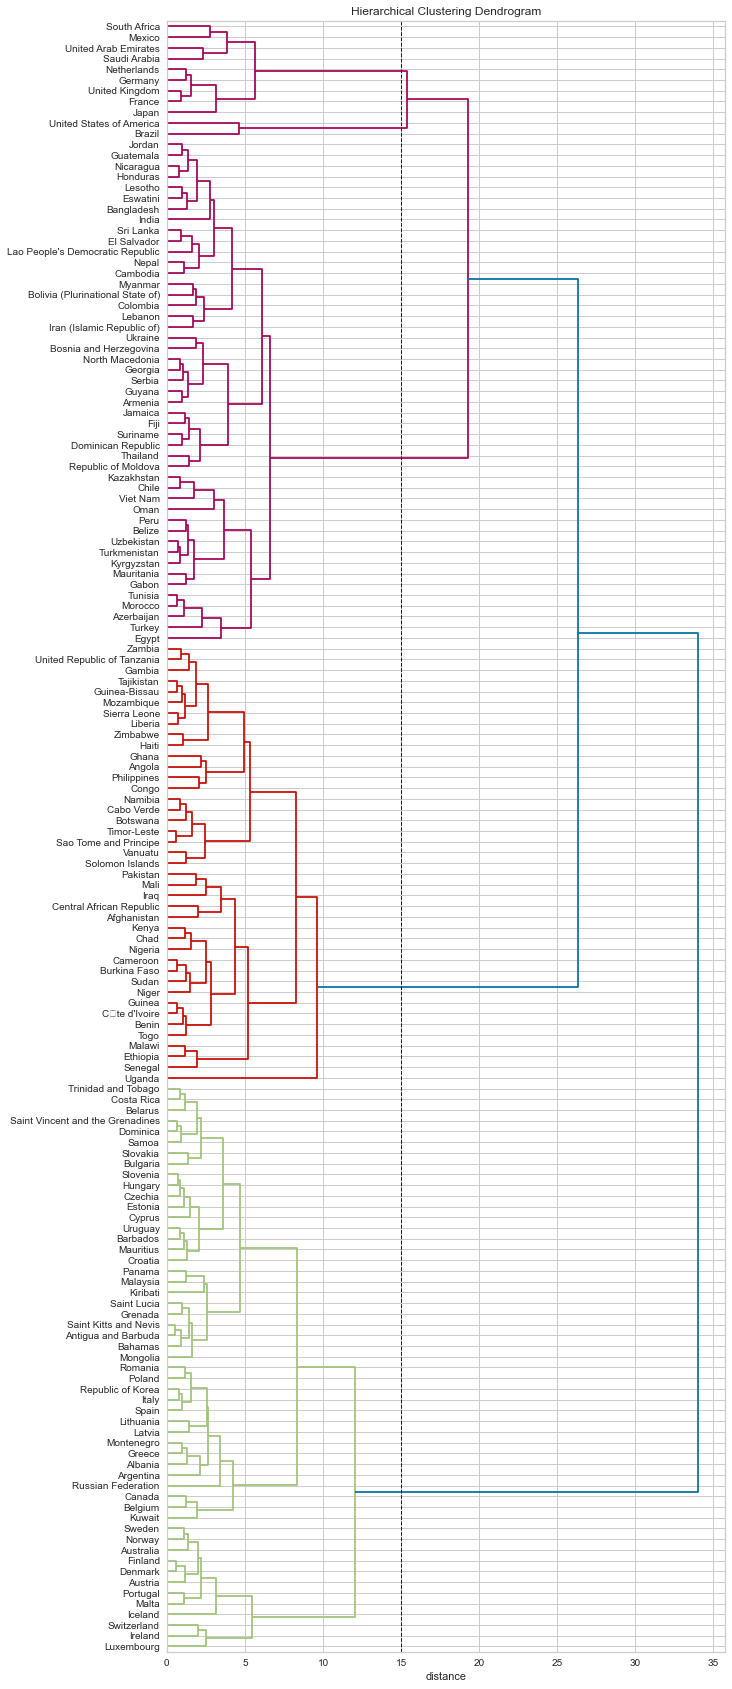

In [41]:
# show dendrogram of the clusters
sample = X_scaled_clustered
Z = linkage(sample, 'ward')
names = sample.index

plt.figure(figsize=(10,30))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('distance')
dendrogram(Z, labels = names, orientation = "right", leaf_font_size=10)

plt.axvline(x=15, c='blue', lw=1, linestyle='dashed')

plt.savefig(fname='Hierarchical Clustering Dendrogram.jpg', dpi=100, format='jpg',
           orientation='vertical', bbox_inches='tight')

plt.show();

In [42]:
# visualize the clusters

# PCA model for dimensionality reduction
pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)

# transform scaled data into the new PCA space
X_reduced = pca.transform(X_scaled)

## QUESTION 5 (visualize clusters on first factorial plane)

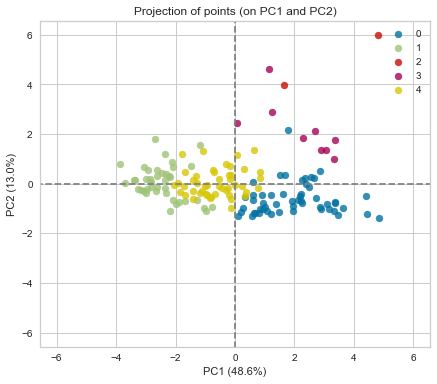

In [43]:
display_factorial_planes(X_reduced, 2, pca, [(0,1)], illustrative_var = clusters, alpha = 0.8)

## QUESTION 3 (describe groups by sample vars)

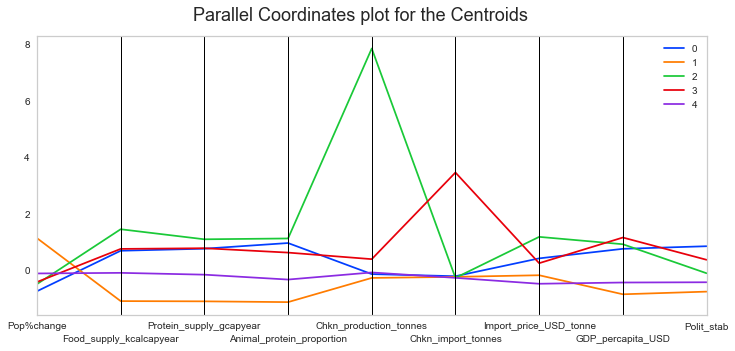

In [44]:
# interpretation of clusters

X_clustered = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_clustered['cluster'] = clusters

# cluster characteristics with parallel plot of means for each variable

means = X_clustered.groupby(by='cluster').mean()
display_parallel_coordinates_centroids(means.reset_index(), 5)

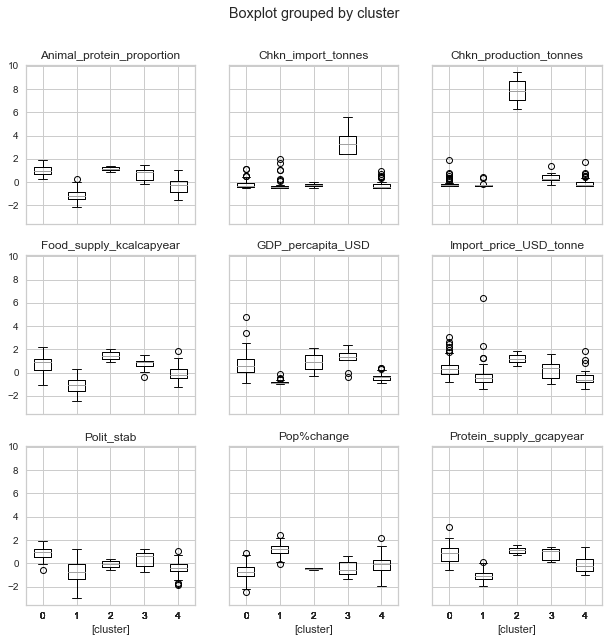

In [45]:
# cluster characteristics with boxplots

X_clustered.boxplot(by='cluster', figsize=(10,10))
plt.show();

In [46]:
# retourner les clusters aux données originales
# return clusters to original data

df_clustered = df.merge(X_scaled_clustered[['cluster']], how='left', on='Area')
df_clustered.groupby('cluster').mean()

,Pop%change,Food_supply_kcalcapyear,Protein_supply_gcapyear,Animal_protein_proportion,Chkn_production_tonnes,Chkn_import_tonnes,Import_price_USD_tonne,GDP_percapita_USD,Polit_stab
cluster,,,,,,,,,
0,2.14,"1,168,681.79","35,756.43",0.58,"393,619.47","41,241.66","2,139.25","35,511.03",0.72
1,12.25,"878,608.41","21,954.93",0.25,"114,032.80","38,239.02","1,551.83","3,964.12",-0.70
2,3.49,"1,292,647.50","38,219.15",0.60,"16,835,634.00","33,678.00","2,887.92","38,697.40",-0.13
3,3.89,"1,179,315.00","35,879.09",0.52,"1,483,113.00","523,045.44","1,971.34","43,350.40",0.29
4,5.52,"1,041,313.94","28,947.61",0.37,"512,390.64","33,708.45","1,255.38","12,130.58",-0.41


### Critique of 5 groups (dendrogram)
group 0 - high animal protein proportion (APP), average chkn production, high import, high import price, high gdp, highest polit stab. GOOD CHOICE

group 1 - high pop increase, min food supply and animal protein proportion, lowest prod of chkn, lowest gpd and polit stab. WORST CHOICE

group 2 - highest APP, highest chkn production volume, high gdp, negative plot stab. BAD CHOICE

group 3 - highest import of chkn, highest gdp, positive polit stab. GOOD CHOICE

group 4 - 2nd highest pop increase, 2nd lowest food supply, 2nd lowest animal protein proportion, 2nd lowest polit stab. WORST CHOICE

In [47]:
# séparer les deux clusters les plus probables pour notre objectif
# separate two most probable clusters for our goal

cluster0 = df_clustered.loc[(df_clustered['cluster'] == 0)]
cluster3 = df_clustered.loc[(df_clustered['cluster'] == 3)]
cluster1 = df_clustered.loc[(df_clustered['cluster'] == 1)] # cluster separation for future statistical tests

cluster0.sort_values(by=['Chkn_import_tonnes'], ascending=False).head(10)

,Pop%change,Food_supply_kcalcapyear,Protein_supply_gcapyear,Animal_protein_proportion,Chkn_production_tonnes,Chkn_import_tonnes,Import_price_USD_tonne,GDP_percapita_USD,Polit_stab,cluster
Area,,,,,,,,,,
Russian Federation,0.65,"1,220,925.00","37,011.00",0.53,"4,606,359.00","216,866.00","1,664.08","27,210.50",-0.54,0
Belgium,2.64,"1,375,685.00","36,452.55",0.59,"440,460.00","208,579.00","1,715.54","51,742.70",0.48,0
Kuwait,10.73,"1,266,915.00","37,671.65",0.48,"56,000.00","140,601.00","1,950.73","49,853.70",0.20,0
Canada,4.65,"1,301,590.00","38,003.80",0.53,"1,328,368.00","138,100.00","2,030.27","49,006.70",1.03,0
Republic of Korea,0.87,"1,248,300.00","36,565.70",0.51,"856,000.00","132,483.00","2,026.06","42,719.00",0.48,0
Spain,0.18,"1,212,530.00","39,255.75",0.62,"1,412,220.00","120,981.00","1,996.64","40,805.90",0.32,0
Romania,-3.51,"1,307,065.00","39,872.60",0.50,"507,106.00","105,781.00","1,362.08","29,857.60",0.53,0
Bulgaria,-3.55,"1,041,710.00","30,389.90",0.48,"88,970.00","96,874.00","1,103.65","23,191.60",0.54,0
Czechia,1.01,"1,196,105.00","31,747.70",0.60,"158,550.00","82,586.00","2,185.19","40,696.30",0.95,0


In [48]:
cluster3.sort_values(by=['Chkn_import_tonnes'], ascending=False).head(10)

,Pop%change,Food_supply_kcalcapyear,Protein_supply_gcapyear,Animal_protein_proportion,Chkn_production_tonnes,Chkn_import_tonnes,Import_price_USD_tonne,GDP_percapita_USD,Polit_stab,cluster
Area,,,,,,,,,,
Mexico,5.64,"1,152,305.00","33,397.50",0.49,"3,476,622.00","803,932.00","1,048.02","19,701.30",-0.71,3
Saudi Arabia,9.31,"1,207,055.00","31,733.10",0.39,"800,000.00","621,589.00","2,032.90","46,962.10",-0.43,3
United Arab Emirates,6.55,"1,209,610.00","40,244.90",0.45,"48,942.00","591,186.00","1,212.92","67,119.20",0.70,3
Japan,-1.19,"987,325.00","31,886.40",0.55,"2,297,886.00","560,381.00","2,211.94","41,380.10",1.04,3
Germany,2.41,"1,297,210.00","38,471.00",0.60,"1,036,000.00","496,552.00","2,404.07","53,639.30",0.58,3
South Africa,6.84,"1,058,135.00","30,795.05",0.43,"1,808,207.00","487,157.00",776.78,"12,481.80",-0.22,3
France,1.26,"1,278,230.00","39,511.25",0.59,"1,121,000.00","383,588.00","2,672.39","45,834.20",0.31,3
United Kingdom,3.03,"1,220,560.00","37,930.80",0.56,"1,723,000.00","382,643.00","3,263.79","46,406.50",0.52,3
Netherlands,1.15,"1,203,405.00","38,941.85",0.65,"1,036,360.00","380,381.00","2,119.25","56,629.10",0.86,3


In [49]:
# réduire la liste des pays en utilisant nos données
# narrow down list of countries using our data

# better way to see which countries heavily rely on imports
country_selection = df_clustered.copy()
country_selection['prod_imp_proportion'] = country_selection['Chkn_import_tonnes'] / country_selection['Chkn_production_tonnes']
country_selection = country_selection.replace([np.inf, -np.inf], 0)
country_selection = country_selection.sort_values(by='prod_imp_proportion', ascending=False)

# remove countries with bad political stability, low animal protein proportion, and with dominant production and\or low imports
country_selection = country_selection.loc[(country_selection['Polit_stab'] >= 0) &
                                          (country_selection['Animal_protein_proportion'] >= 0.50) & 
                                          (country_selection['prod_imp_proportion'] >= 1.50)]

# sort by richest countries among those
country_selection = country_selection.sort_values(by='GDP_percapita_USD', ascending=False)

## QUESTION 4 (list of countries to target)

In [50]:
# by import quantity
#cluster0: Belgium, Kuwait, Romania, Bulgaria, Czechia, Ireland
#cluster3: UAE, Germany, UK, Netherlands

# by production quantity
#cluster0: Saint Kitts and Nevis, Antigua and Barbuda, Mongolia, Luxembourg, Samoa
#cluster3: UAE, Germany, Netherlands, UK

# by excluding countries with low import\produce ratio, low animal protein use, bad polit stab, etc.
# 'Luxembourg', 'Bahamas', 'Antigua and Barbuda', 'Montenegro', 'Grenada', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Mongolia', 'Dominica', 'Samoa'

country_selection.index.name = 'Country'
country_selection.to_csv('target_countries.csv')
country_selection

,Pop%change,Food_supply_kcalcapyear,Protein_supply_gcapyear,Animal_protein_proportion,Chkn_production_tonnes,Chkn_import_tonnes,Import_price_USD_tonne,GDP_percapita_USD,Polit_stab,cluster,prod_imp_proportion
Country,,,,,,,,,,,
Luxembourg,9.93,"1,264,725.00","39,657.25",0.62,294.00,"7,816.00","4,745.64","113,940.00",1.36,0,26.59
Bahamas,4.96,"969,075.00","29,451.85",0.64,"6,206.00","19,536.00","1,988.17","37,100.40",0.83,0,3.15
Antigua and Barbuda,4.56,"892,425.00","29,269.35",0.64,32.00,"5,944.00","1,938.10","21,548.70",0.96,0,185.75
Montenegro,0.18,"1,277,500.00","41,803.45",0.61,"3,769.00","7,268.00","2,224.23","21,533.90",0.01,0,1.93
Grenada,2.63,"876,730.00","26,031.80",0.56,415.00,"6,101.00","1,643.51","17,050.30",0.96,0,14.70
Saint Lucia,2.48,"955,570.00","31,324.30",0.61,"1,429.00","3,544.00","1,320.26","15,448.30",0.93,0,2.48
Saint Vincent and the Grenadines,1.63,"1,083,320.00","32,915.70",0.56,452.00,"7,219.00","1,389.40","12,484.70",0.96,0,15.97
Mongolia,8.92,"941,335.00","31,868.15",0.65,192.00,"11,642.00","1,859.90","12,316.80",0.64,0,60.64
Dominica,1.12,"1,077,480.00","28,864.20",0.57,362.00,"3,916.00","1,620.73","11,905.90",1.07,0,10.82


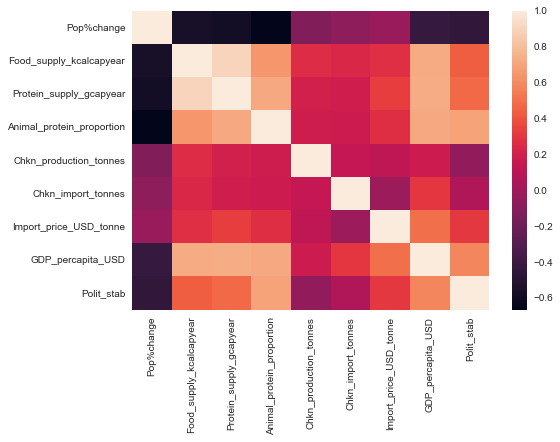

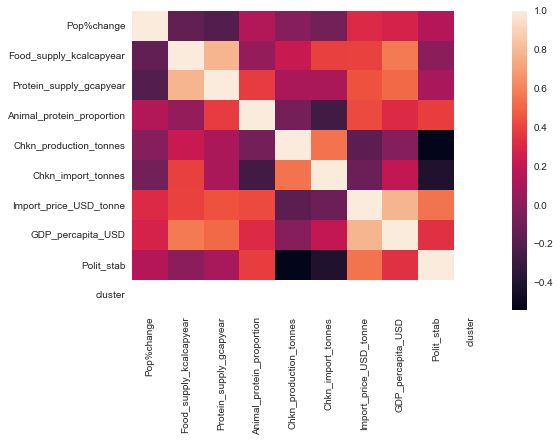

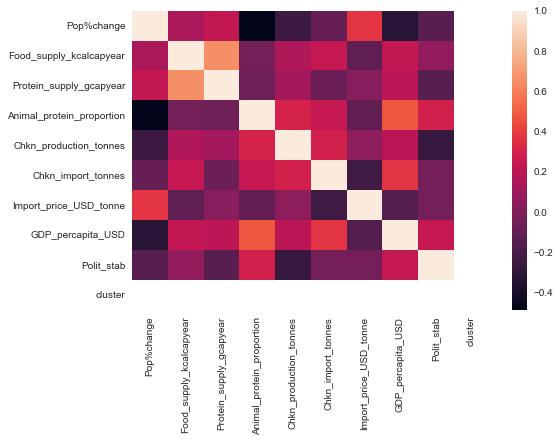

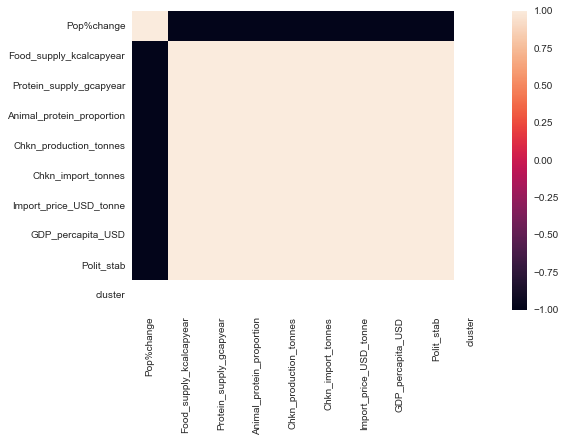

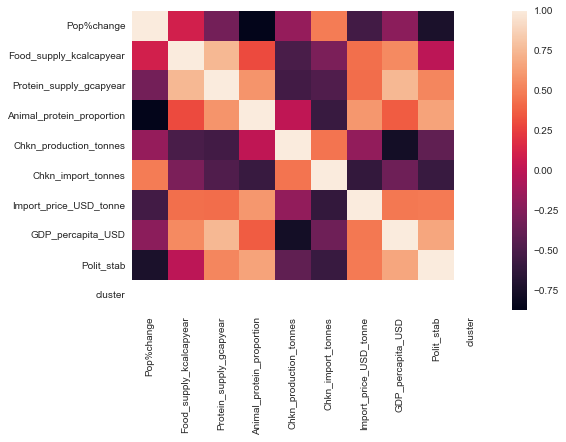

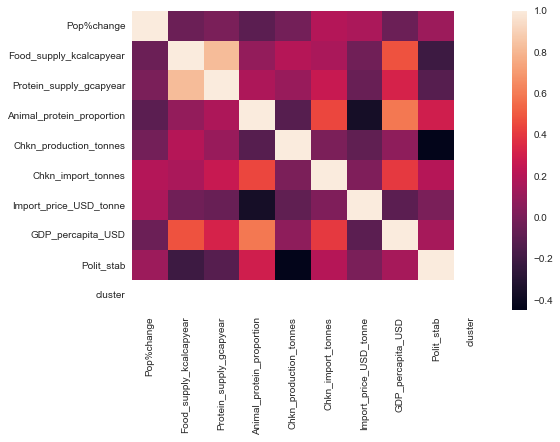

In [51]:
# correlation heatmaps

# all data
sns.heatmap(df_clustered.iloc[:,:-1].corr())
plt.show();

# individual clusters
sns.heatmap(df_clustered.loc[df_clustered['cluster']==0].corr())
plt.show();
sns.heatmap(df_clustered.loc[df_clustered['cluster']==1].corr())
plt.show();
sns.heatmap(df_clustered.loc[df_clustered['cluster']==2].corr())
plt.show();
sns.heatmap(df_clustered.loc[df_clustered['cluster']==3].corr())
plt.show();
sns.heatmap(df_clustered.loc[df_clustered['cluster']==4].corr())
plt.show();

## PCA v2

In [52]:
# get data
X = df.copy()

# data standartization
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

# select num of PC and do PCA
num_components = 5

pca = decomposition.PCA(n_components=num_components)

pca.fit(X_scaled)

PCA(n_components=5)

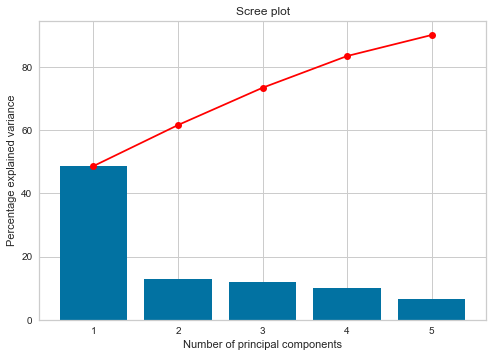

[0.48603621 0.61569359 0.73359211 0.83388456 0.90034747]


In [53]:
# scree plot for variance vs PC
display_scree_plot(pca)

print(pca.explained_variance_ratio_.cumsum())

In [54]:
pc1 = pca.components_[0]
pc2 = pca.components_[1]
pc3 = pca.components_[2]
pc4 = pca.components_[3]
pc5 = pca.components_[4] 

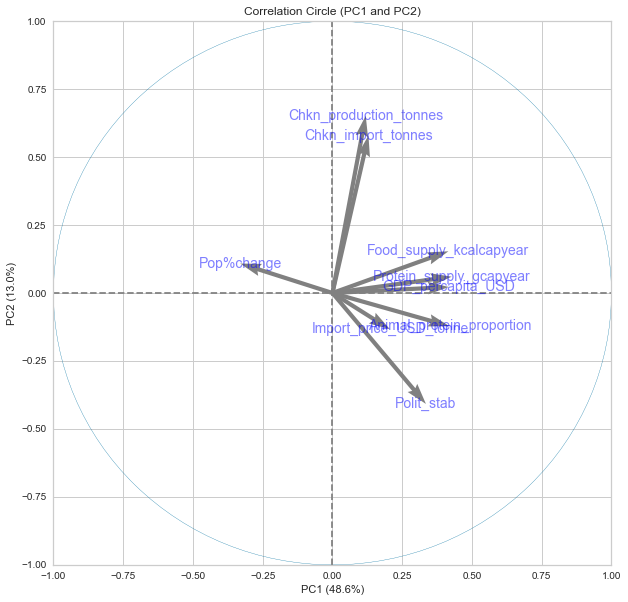

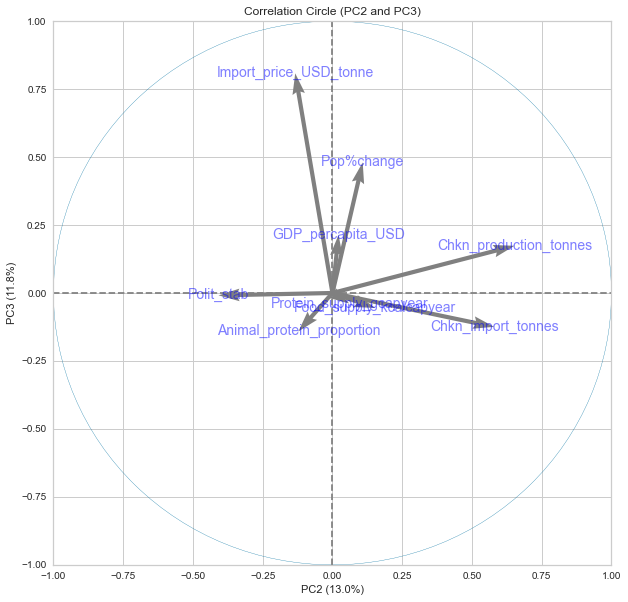

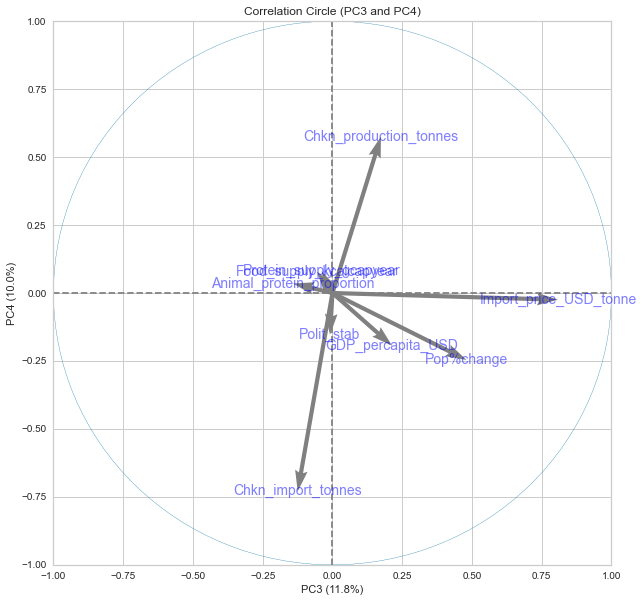

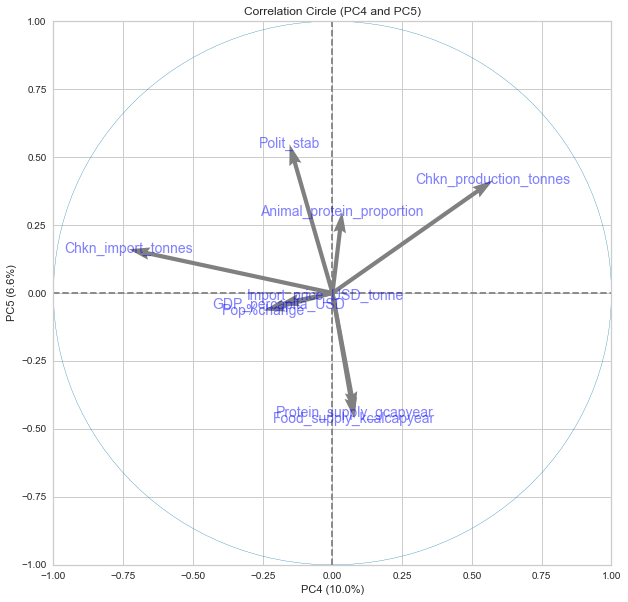

In [55]:
# correlation circle
pcs = pca.components_
display_circles(pcs, num_components, pca, [(0,1)], labels=np.array(X.columns))
display_circles(pcs, num_components, pca, [(1,2)], labels=np.array(X.columns))
display_circles(pcs, num_components, pca, [(2,3)], labels=np.array(X.columns))
display_circles(pcs, num_components, pca, [(3,4)], labels=np.array(X.columns))

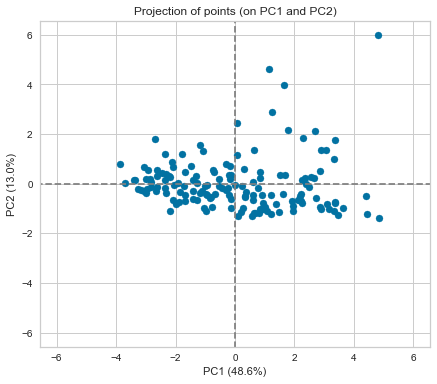

In [56]:
# individuals factor map

# transform original scaled data to the new vector space
X_projected = pca.transform(X_scaled)

# display scatter plot for this new vectSpace
display_factorial_planes(X_projected, num_components, pca, [(0,1)])
plt.show();

In [57]:
X_clustered = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_clustered['cluster'] = clusters

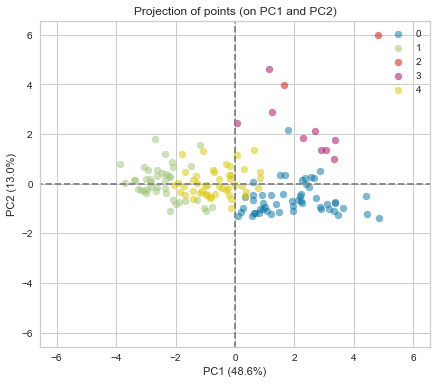

In [58]:
# all clusters on 1st factorial plane
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, num_components, pca, [(0,1)], illustrative_var = clusters, alpha = 0.5)

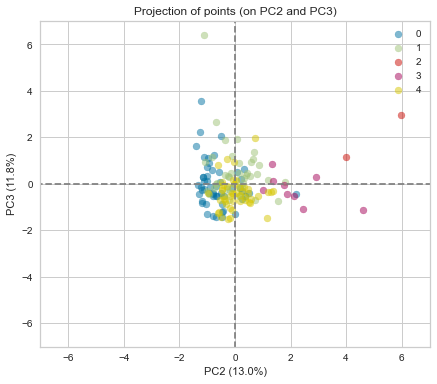

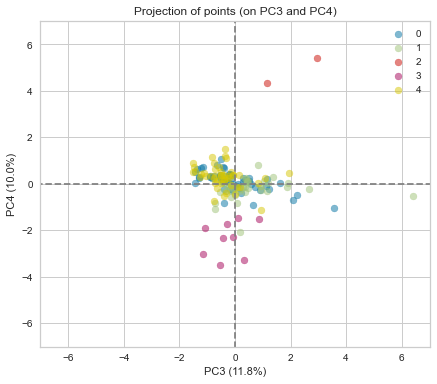

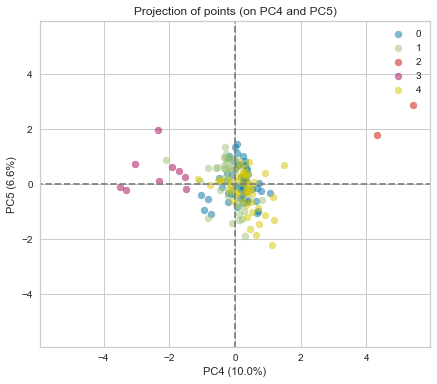

In [59]:
# individual factor maps

X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, num_components, pca, 
                         [(1,2),(2,3),(3,4)], illustrative_var = clusters, alpha = 0.5)

## K-means v2

In [60]:
# get data
X = df.copy()

# standardizing the data
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

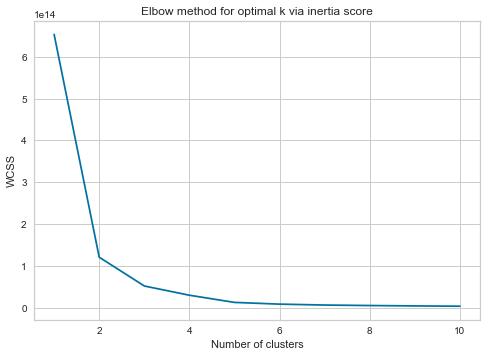

In [61]:
# determine optimal amount of clusters

wcss = [] # within cluster sum of squares

for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 20)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow method for optimal k via inertia score')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show();

In [62]:
# Kmeans clustering model
kmeans = KMeans(init='k-means++', n_clusters=5, max_iter=300, n_init=20)

# fit data to the model
kmeans.fit_predict(X_scaled)

# trace each datapoint to its corresponding cluster
clusters = kmeans.predict(X_scaled)

# add cluster number to the original data
X_scaled_clustered = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_clustered['cluster'] = clusters

X_scaled_clustered['cluster'].value_counts()

4    57
0    51
3    32
1    10
2     2
Name: cluster, dtype: int64

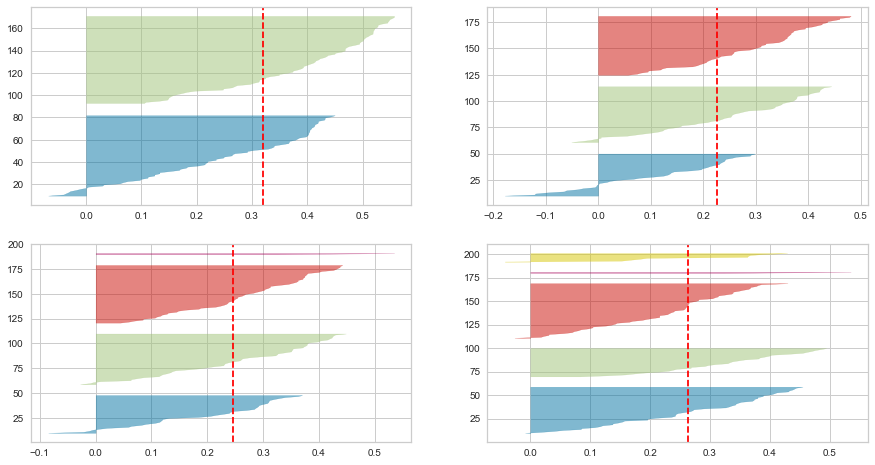

In [63]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    # Create KMeans instance for different number of clusters
    km = KMeans(n_clusters=i, init='k-means++', n_init=20, max_iter=300)
    q, mod = divmod(i, 2)
    # Create SilhouetteVisualizer instance with KMeans instance
    # Fit the visualizer
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_scaled)

According to elbow curve and silhouette scores, possible number of clusters is 3 or 5.

In [64]:
# visualize clusters
pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)

X_reduced = pca.transform(X_scaled)

In [65]:
# convert into a dataframe
X_reduceddf = pd.DataFrame(X_reduced, index=X.index, columns=['PC1', 'PC2'])
X_reduceddf['cluster'] = clusters
X_reduceddf.head()

,PC1,PC2,cluster
Area,,,
Afghanistan,-3.87,0.79,0
Albania,1.61,-0.43,3
Angola,-2.34,1.18,0
Antigua and Barbuda,0.57,-1.32,4
Argentina,1.53,0.34,4


### visualize Centroids

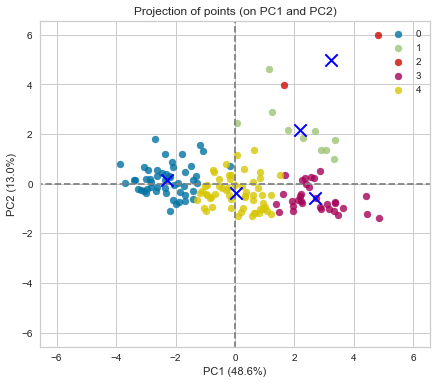

In [66]:
# visualize cluster centers
centres_reduced = pca.transform(kmeans.cluster_centers_)

display_factorial_planes(X_reduced, 2, pca, [(0,1)], illustrative_var = clusters, alpha=0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
           marker='x', s=152, linewidth=2, color='blue', zorder=10)

### clusters centers into csv

In [67]:
# center of each cluster
cluster_centers = pd.DataFrame(data=centres_reduced, columns=['PC1', 'PC2'], dtype=np.float64)

# add centroids of each variable
cluster_centers = cluster_centers.merge(means, how='left', on=cluster_centers.index)
cluster_centers.index.name = 'cluster'
cluster_centers = cluster_centers.drop(columns=['key_0'])

cluster_centers.to_csv('clusters_centers.csv')

cluster_centers

,PC1,PC2,Pop%change,Food_supply_kcalcapyear,Protein_supply_gcapyear,Animal_protein_proportion,Chkn_production_tonnes,Chkn_import_tonnes,Import_price_USD_tonne,GDP_percapita_USD,Polit_stab
cluster,,,,,,,,,,,
0,-2.29,0.16,-0.72,0.71,0.78,0.98,-0.12,-0.19,0.44,0.78,0.87
1,2.19,2.16,1.15,-1.07,-1.08,-1.11,-0.25,-0.22,-0.16,-0.83,-0.74
2,3.23,4.98,-0.47,1.47,1.11,1.14,7.85,-0.25,1.20,0.94,-0.09
3,2.69,-0.59,-0.40,0.77,0.80,0.64,0.41,3.47,0.27,1.17,0.39
4,0.04,-0.36,-0.09,-0.07,-0.14,-0.31,-0.06,-0.25,-0.46,-0.41,-0.41


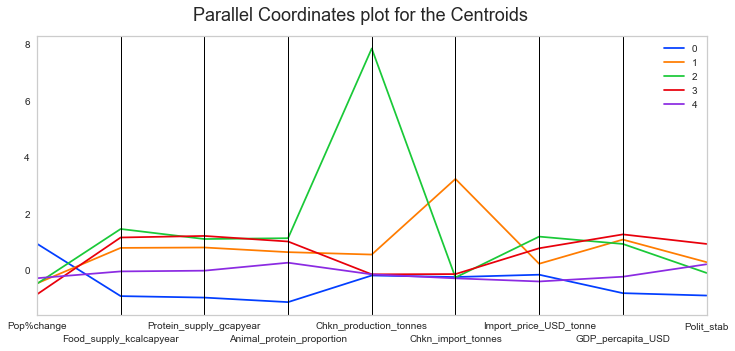

In [68]:
# interpreting meaning of clusters
X_clustered = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_clustered['cluster'] = clusters

# visualizing characteristics of each cluster by variable mean
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids['cluster'] = centroids.index

display_parallel_coordinates_centroids(centroids, 5)

In [69]:
# sélection des pays par clusters KMeans
# country selection by KMeans clusters

df_clustered2 = df.merge(X_clustered[['cluster']], how='left', on='Area')

# better data to see which countries heavily rely on imports
country_selection2 = df_clustered2.copy()
country_selection2['prod_imp_proportion'] = country_selection2['Chkn_import_tonnes'] / country_selection2['Chkn_production_tonnes']

country_selection2 = country_selection2.replace([np.inf, -np.inf], 0)
country_selection2 = country_selection2.sort_values(by='prod_imp_proportion', ascending=False)

# remove countries with bad political stability, low animal protein proportion, and with dominant production and\or low imports
country_selection2 = country_selection2.loc[(country_selection2['Polit_stab'] >= 0) &
                                            (country_selection2['Animal_protein_proportion'] >= 0.50) &
                                            (country_selection2['prod_imp_proportion'] >= 1.50)]

# sort by richest countries among those
country_selection2 = country_selection2.sort_values(by='GDP_percapita_USD', ascending=False)

country_selection2

,Pop%change,Food_supply_kcalcapyear,Protein_supply_gcapyear,Animal_protein_proportion,Chkn_production_tonnes,Chkn_import_tonnes,Import_price_USD_tonne,GDP_percapita_USD,Polit_stab,cluster,prod_imp_proportion
Area,,,,,,,,,,,
Luxembourg,9.93,"1,264,725.00","39,657.25",0.62,294.00,"7,816.00","4,745.64","113,940.00",1.36,3,26.59
Bahamas,4.96,"969,075.00","29,451.85",0.64,"6,206.00","19,536.00","1,988.17","37,100.40",0.83,4,3.15
Antigua and Barbuda,4.56,"892,425.00","29,269.35",0.64,32.00,"5,944.00","1,938.10","21,548.70",0.96,4,185.75
Montenegro,0.18,"1,277,500.00","41,803.45",0.61,"3,769.00","7,268.00","2,224.23","21,533.90",0.01,3,1.93
Grenada,2.63,"876,730.00","26,031.80",0.56,415.00,"6,101.00","1,643.51","17,050.30",0.96,4,14.70
Saint Lucia,2.48,"955,570.00","31,324.30",0.61,"1,429.00","3,544.00","1,320.26","15,448.30",0.93,4,2.48
Saint Vincent and the Grenadines,1.63,"1,083,320.00","32,915.70",0.56,452.00,"7,219.00","1,389.40","12,484.70",0.96,4,15.97
Mongolia,8.92,"941,335.00","31,868.15",0.65,192.00,"11,642.00","1,859.90","12,316.80",0.64,4,60.64
Dominica,1.12,"1,077,480.00","28,864.20",0.57,362.00,"3,916.00","1,620.73","11,905.90",1.07,4,10.82


In [70]:
# Le résultat est le même que le regroupement via le dendrogramme et la sélection du meilleur d'entre eux.
# result is the same as clustering via dendrogram and selecting best from it

## Statistical tests

### Test d'adequation

Goodness-of-fit test to find a variable with normal distribution.
All our variables are continuous, we use Kolmogorov-Smirnov test.

In [71]:
# Kolmogorov-Smirnov (for continuous variable)
print(ks_2samp(df['Pop%change'],
         list(np.random.normal(np.mean(df['Pop%change']), np.std(df['Pop%change']), 1000))))

# Shapiro-Wilk
print(stats.shapiro(df['Pop%change']))

KstestResult(statistic=0.0751578947368421, pvalue=0.42253697501025533)
ShapiroResult(statistic=0.9866617321968079, pvalue=0.15317919850349426)


pvalue = 0,4, nous ne rejetons pas N0 (la distribution est normale) au niveau de confiance de 5%;\
pvalue = 0.4, we do not reject N0 (distribution is normal) at 5% confidence level;

In [72]:
print(ks_2samp(df['GDP_percapita_USD'],
         list(np.random.normal(np.mean(df['GDP_percapita_USD']), np.std(df['GDP_percapita_USD']), 1000))))

print(stats.shapiro(df['GDP_percapita_USD']))

KstestResult(statistic=0.18, pvalue=0.00032549314740260016)
ShapiroResult(statistic=0.837209939956665, pvalue=1.0521641717609054e-11)


La valeur p est très faible, nous rejetons donc N0 et acceptons l'hypothèse alternative selon laquelle la distribution n'est PAS normale, avec un niveau de confiance de 5 %;\
pvalue is very small hence we reject N0 and accept Alternative Hypothesis that distribution is NOT normal, at 5% confidence level;

### test de comparaison de deux populations (dans le cas gaussien)

Among 2 clusters, test Gaussian variable using comparison test

In [73]:
# save variables to test as new objects

cl0_pop = cluster0['Pop%change']
cl1_pop = cluster1['Pop%change']

cl0_gdp = cluster0['GDP_percapita_USD']
cl1_gdp = cluster1['GDP_percapita_USD']

#### equality of variances

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html
\
Bartlett’s test tests the null hypothesis that all input samples are from populations with equal variances.

In [74]:
scipy.stats.bartlett(cl0_pop, cl1_pop)

BartlettResult(statistic=2.2949589049547128, pvalue=0.12979464612085712)

pvalue = 0.12, nous ne rejetons pas N0 (égalité des variances) à un niveau de confiance de 5% ;\
pvalue = 0.12, we do not reject N0 (equality of variances) at 5% test confidence;

In [75]:
scipy.stats.bartlett(cl0_gdp, cl1_gdp)

BartlettResult(statistic=96.33709430753933, pvalue=9.689745963772276e-23)

La valeur p est très faible, donc nous rejetons N0 et acceptons l'hypothèse alternative avec un niveau de confiance de 5% (les variances ne sont PAS égales) ;\
pvalue is very small, hence we reject N0 and accept Alternative hypothesis at 5% test confidence (variances are NOT equal);

#### equality of means
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
\
two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values.
This test assumes that the populations have identical variances by default.

In [76]:
scipy.stats.ttest_ind(cl0_pop, cl1_pop, equal_var=True)

Ttest_indResult(statistic=-14.523115790467816, pvalue=1.5437377159055225e-25)

La valeur p est très faible, donc nous rejetons N0 et acceptons l'hypothèse alternative avec un niveau de confiance de 5% (les moyennes ne sont PAS égales) ;\
pvalue is very small, hence we reject N0 and accept Alternative hypothesis at 5% test confidence (means are NOT equal);

In [77]:
scipy.stats.ttest_ind(cl0_gdp, cl1_gdp, equal_var=True)

Ttest_indResult(statistic=9.92253790864671, pvalue=3.3230010104369944e-16)

La valeur p est très faible, donc nous rejetons N0 et acceptons l'hypothèse alternative avec un niveau de confiance de 5% (les moyennes ne sont PAS égales) ;\
pvalue is very small, hence we reject N0 and accept Alternative hypothesis at 5% test confidence (means are NOT equal);

Conclusions générales :
Grâce aux tests effectués, nous pouvons affirmer avec confiance que nos échantillons (clusters) sont différents.
\
Overall conclusions:
Thanks to the carried out tests, we can confidently say that our samples (clusters) are different.

-----
## Conclusions générales après l'analyse effectuée :

Globalement, nous voyons 2 clusters viables pour les importations de viande de poulet - le cluster 0 et le cluster 3.

Caractéristiques du cluster 0 - proportion élevée de protéines animales, production moyenne de poulet, importations élevées, prix d'importation élevé, PIB élevé, stabilité politique maximale.
Groupe 3 - importations de poulet les plus élevées, PIB le plus élevé, stabilité politique positive.

La majorité d'entre eux sont des pays insulaires en développement qui n'ont pas de grandes possibilités de production et dont le régime alimentaire est fortement axé sur les protéines d'origine animale. La liste complète se trouve dans target_countries.csv.

----
General conclusions after performed analysis:

Overall we see 2 viable clusters for chicken meat imports - cluster 0 and cluster 3.

Cluster 0 characteristics - high animal protein proportion, average chicken production, high import, high import price, high gdp, highest political stability.
Cluster 3 - highest import of chicken, highest gdp, positive political stability.

Best countries to target for chicken meat imports belong to cluster 0. Majority of them are developing island nations that do not have high production possibilities while population diet realies heavily on protein of animal origin. Full list can be found in target_countries.csv

----
### README
    
Étude de marché pour une entreprise de production de viande de poulet

Etape 1

Importez les bibliothèques python nécessaires.
Définir le répertoire de travail comme un dossier contenant les données brutes.
Charger les données brutes (téléchargées depuis la FAO) dans les cadres de données Pandas.
Explorer les données brutes pour mieux les comprendre.
Effectuez le nettoyage si nécessaire.

Étape 2

Fusionnez toutes les données brutes en un seul cadre de données.
Effectuez divers regroupements sur nos données :
- Clustering hiérarchique (Dendrogramme)
- ACP
- KMeans

Étape 3

Tests statistiques.

----
README:
    
Market research for chicken meat production company

Step 1

Import necessary python libraries.
Set working directory as a folder with raw data.
Load raw data (downloaded from FAO) into Pandas dataframes.
Explore raw data to gain better understanding about it.
Perform cleaning where necessary.

Step 2

Merge all raw data into single dataframe.
Perform various clustering on our data:
- Hierarchical clustering (Dendrogramm)
- PCA
- KMeans

Step 3

Statistical tests.